# PUN index (GME) — Daily Forecasting with Terna Generation & Load data

This notebook builds a simple **day-ahead forecasting pipeline** for the Italian electricity price (**PUN index, GME**), using public **Terna** data:
- generation by source (wind, photovoltaic, hydro, geothermal, thermal)
- total load, plus Terna’s **forecasted total load**

The goal is to keep everything **clean and reproducible**, showing a standard **time-series workflow**:
data loading, exploratory plots, lag analysis, and a baseline forecasting model compared to a **linea regression model**.

**Main design choice:** the model predicts the **PUN at day D** using only information available up to **day D-1**.  
The only exception is **forecasted total load**, which is a Terna day-ahead estimate published for **D** (so it can be treated as available before delivery).


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Dataset construction

This dataset is built from public sources and then aggregated at **daily granularity**.

- **PUN (GME)**: daily average of the PUN price published by GME (MGP market results).  
  Unit: **€/MWh**.  
  Source: https://www.mercatoelettrico.org/en-us/Home/Results/Electricity/MGP/Results/PUN

- **Terna generation and load**: generation by source (wind, photovoltaic, hydro, geothermal, thermal) and total load downloaded from Terna’s data portal.  
  Unit in the original data is **MW** for total_load and forecasted_total_load, while **GW** for the generations.  
  In this dataset the values are already aggregated as **daily averages** (mean over the day).  
  Source: https://dati.terna.it/en/download-center


In [39]:
dataset = pd.read_csv("dataset.csv", sep=";", decimal=",")


# convert load units to GW
for c in ["total_load", "forecast_total_load"]:
    dataset[c] = dataset[c] / 1000


dataset.head()



,Data,price,total_load,forecast_total_load,geothermal,hydro,photovoltaic,thermal,wind
0,01/01/2022,150.689166,24.413833,24.409698,0.645000,3.127500,1.095833,9.997500,1.961250
1,02/01/2022,167.212316,25.555271,25.372073,0.650000,2.892083,0.957500,11.136667,1.984167
2,03/01/2022,193.642835,32.201219,32.300573,0.648750,2.806667,0.880833,15.685000,3.199167
3,04/01/2022,166.092295,33.307229,33.599917,0.650000,2.820417,0.776250,16.473333,4.322917
4,05/01/2022,192.537931,33.264083,33.778281,0.646667,3.199583,0.884167,15.604583,5.097917


## Step 1 — Plot the time series of each variable

Here we:
- Parse the date column
- Sort by date
- Plot one line chart per variable converting the features from MW to GW


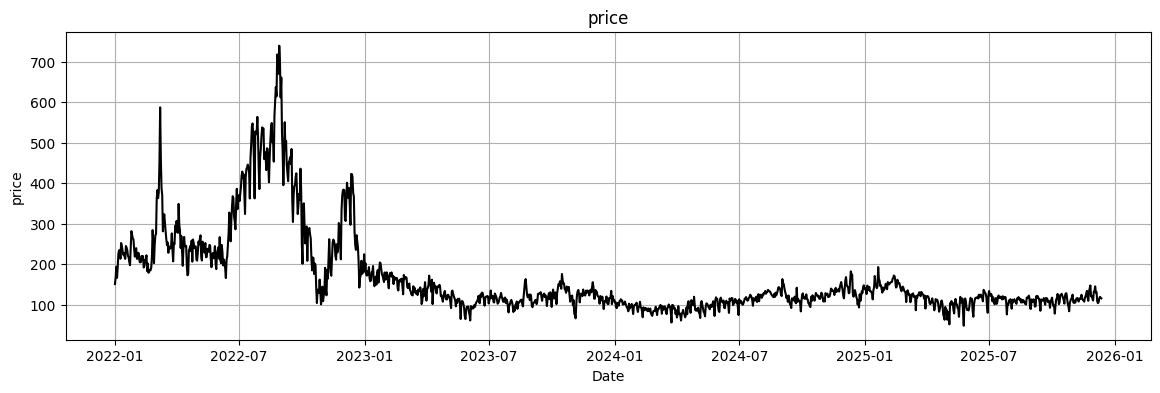

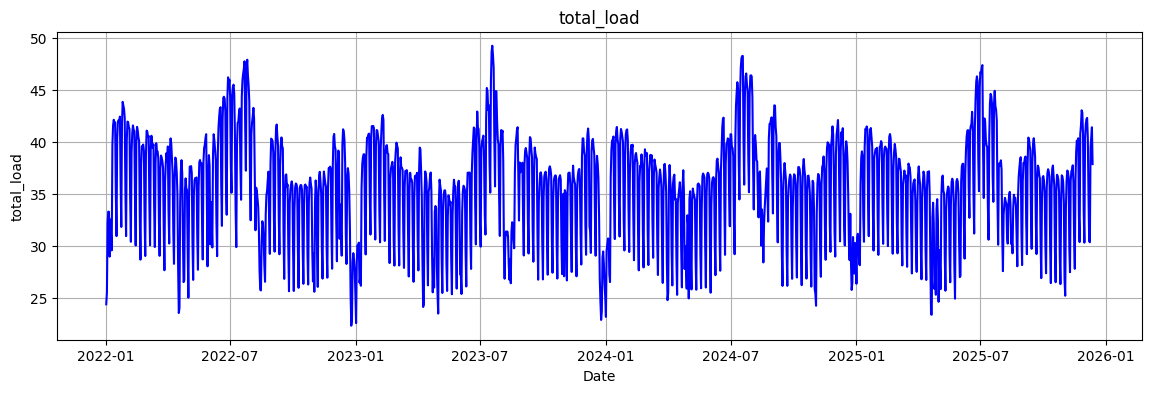

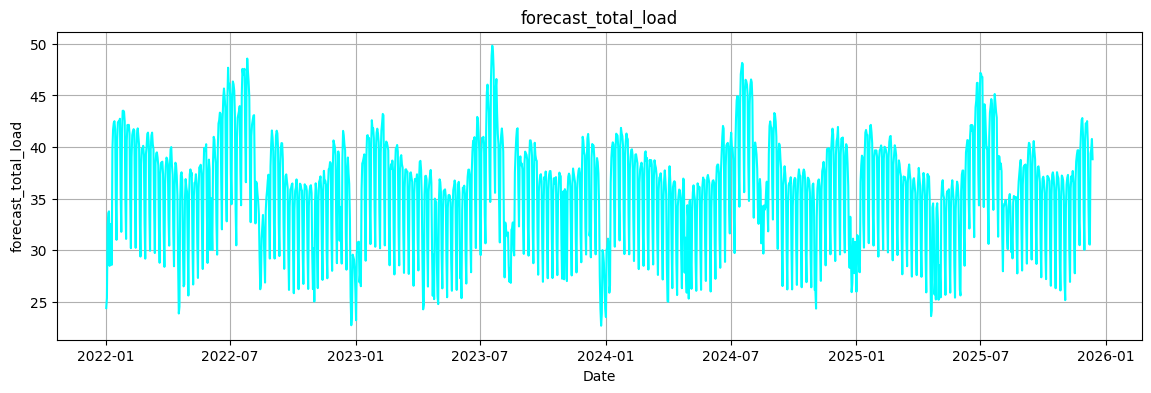

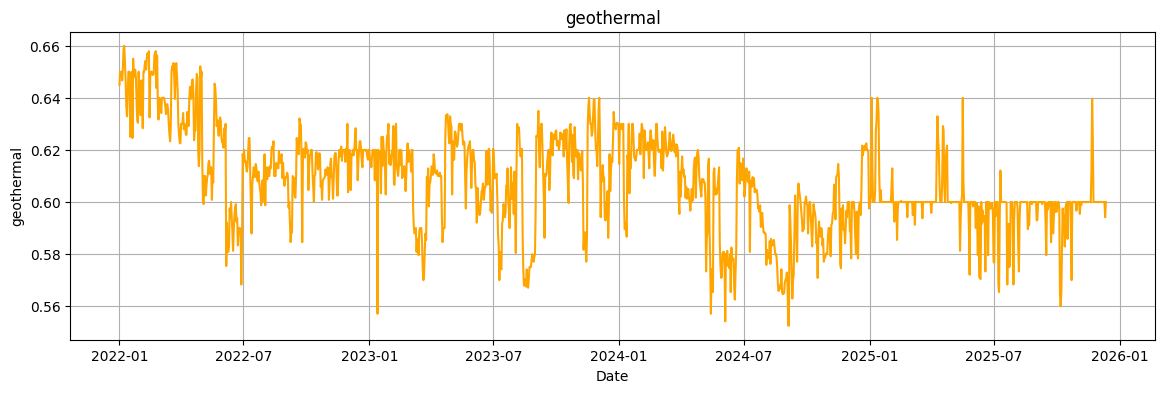

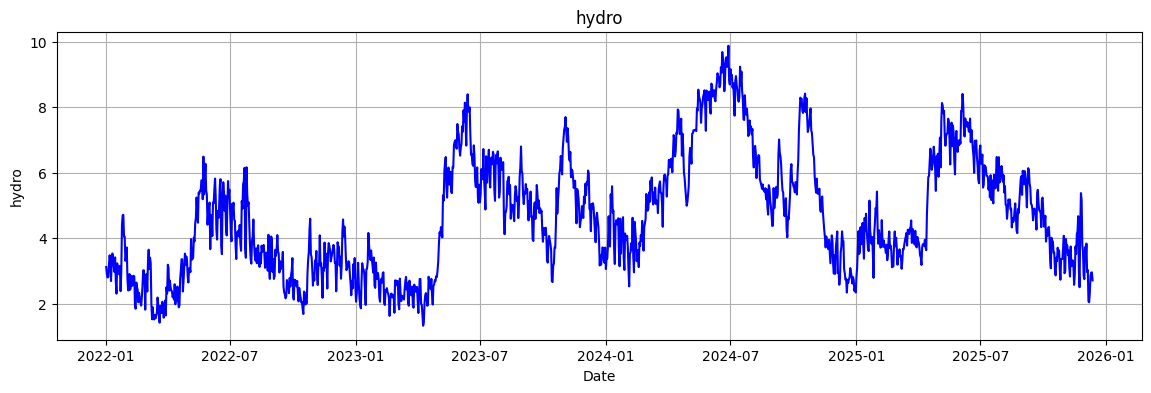

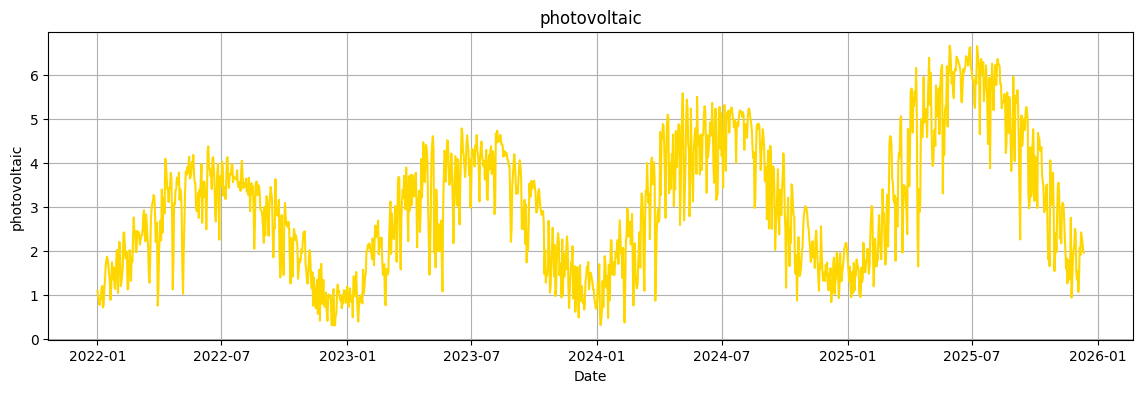

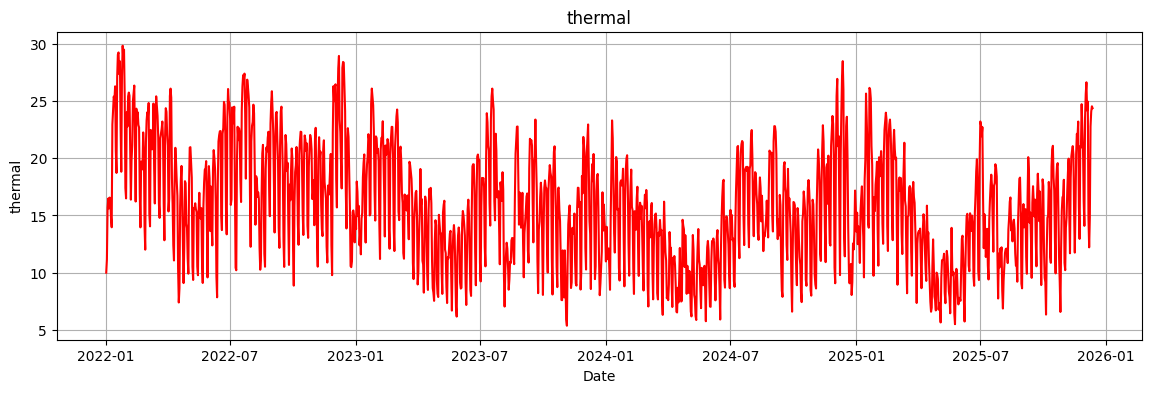

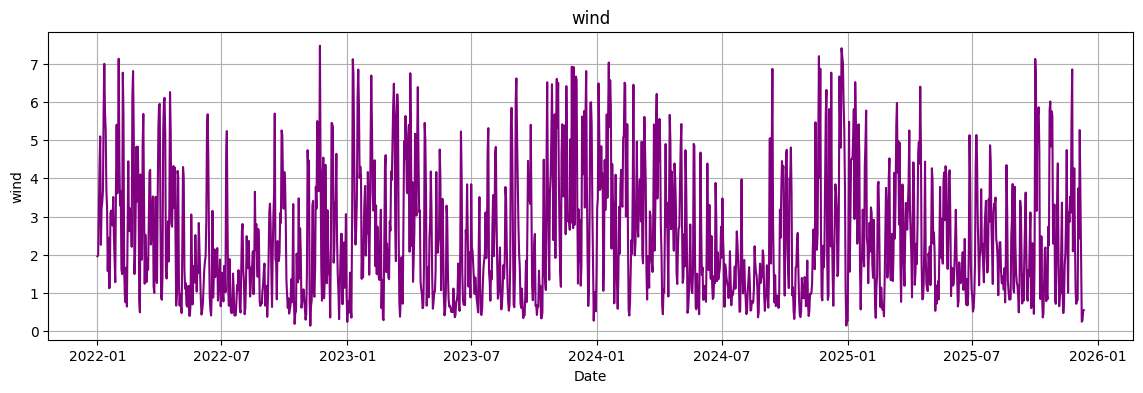

In [40]:
# Ensure the date column is datetime and sorted
dataset["Data"] = pd.to_datetime(dataset["Data"], dayfirst=True)
dataset = dataset.sort_values("Data")

cols_to_plot = [c for c in dataset.columns if c != "Data"]

# colors based on current column names (with units)
colors = {
    "price": "black",
    "total_load": "blue",
    "forecast_total_load": "cyan",
    "geothermal": "orange",
    "hydro": "blue",
    "photovoltaic": "gold",
    "thermal": "red",
    "wind": "purple",
}

for c in cols_to_plot:
    plt.figure(figsize=(14, 4))
    plt.plot(dataset["Data"], dataset[c], color=colors.get(c, "grey"))
    plt.title(c)
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.grid(True)
    plt.show()


## Step 2— Correlation matrix

We will:
- Select only numeric columns
- Compute the correlation matrix
- Show it as a table


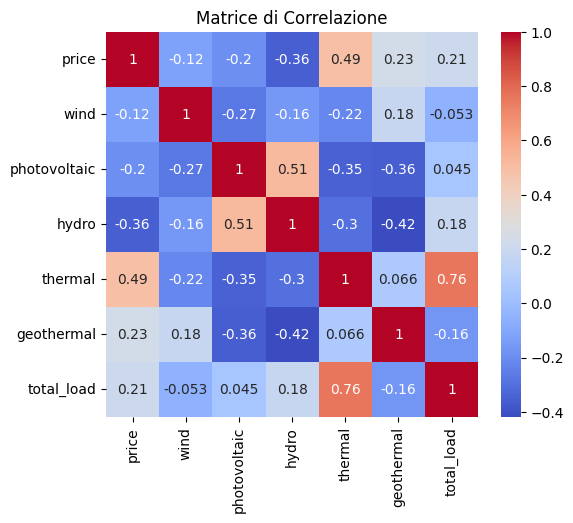

In [41]:
data = [
    "price",
    "wind",
    "photovoltaic",
    "hydro",
    "thermal",
    "geothermal",
    "total_load"
]

plt.figure(figsize=(6, 5))
corr_matrix = dataset[data].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matrice di Correlazione')
plt.show()


## Forecasting setup (linear regression)


The goal is to predict the price at day **D** using:
- past information (yesterday / last week price)
- Terna variables from the previous day (wind, photovoltaic, total load)
- Terna **day-ahead forecast** for total load

As a reference I use a **naive baseline**:
$$
\hat{P}_D = P_{D-1}
$$
i.e. “tomorrow ≈ yesterday”. This helps to check if a model is actually adding value.

Then I train a **linear regression** on the selected lag features.  
Before fitting the model we apply a **StandardScaler**, computed on the training set only. For each feature $x$:
$$
x' = \frac{x - \mu}{\sigma}
$$
where $\mu$ and $\sigma$ are the mean and standard deviation estimated on the training data.  


Finally we evaluate on a chronological test set (last 20% of the data) using MAE, MSE and $R^2$, and I plot observed vs predicted prices.



Naive baseline (price_lag_1)
Mean Absolute Error: 9.329248400696864
Mean Squared Error: 168.8386986864089
R^2 Score: 0.2367843653641456
----------------------------------------
Linear Regression (lag features)
Mean Absolute Error: 7.77686218271106
Mean Squared Error: 96.88923782362822
R^2 Score: 0.5620235069905972


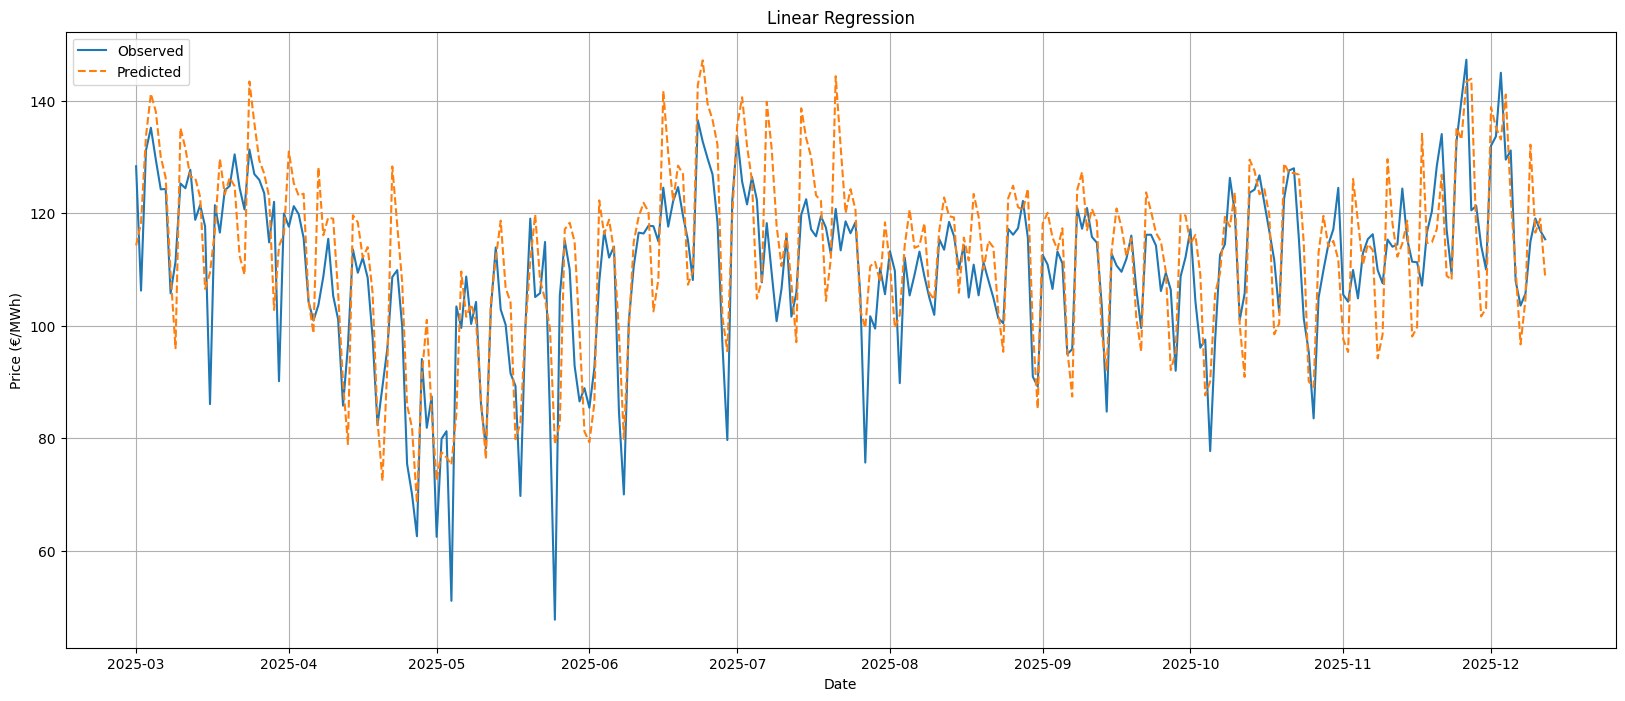

Intercept: 178.06715890418118
price_lag_1 : 101.31586866494919
price_lag_7 : 9.632262696339176
wind_lag_1 : 1.4520286433212617
photovoltaic_lag_1 : 2.074276406671972
total_load_lag_1 : -13.955916223902149
forecast_total_load_same_day : 14.949516952678293


In [44]:
# Make sure the data is sorted by date
dataset["Data"] = pd.to_datetime(dataset["Data"], dayfirst=True)
dataset = dataset.sort_values("Data").reset_index(drop=True)

# Build lagged features (use yesterday info to predict today price)
df = dataset.copy()

df["price_lag_1"] = df["price"].shift(1)
df["price_lag_7"] = df["price"].shift(7)

df["wind_lag_1"] = df["wind"].shift(1)
df["photovoltaic_lag_1"] = df["photovoltaic"].shift(1)
df["total_load_lag_1"] = df["total_load"].shift(1)

# forecast_total_load is known day-ahead
df["forecast_total_load_same_day"] = df["forecast_total_load"]

# Drop rows with NaNs created by shifting
df = df.dropna().reset_index(drop=True)

# Select features and target
features = [
    "price_lag_1",
    "price_lag_7",
    "wind_lag_1",
    "photovoltaic_lag_1",
    "total_load_lag_1",
    "forecast_total_load_same_day",
]
X = df[features]
y = df["price"]

# Time-based split: train 80%, test 20%
split_idx = int(0.8 * len(df))

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

# Baseline: "tomorrow ~ yesterday" (use price_lag_1)
y_pred_naive = df["price_lag_1"].iloc[split_idx:].values

mae_naive = mean_absolute_error(y_test, y_pred_naive)
mse_naive = mean_squared_error(y_test, y_pred_naive)
r2_naive = r2_score(y_test, y_pred_naive)

print("Naive baseline (price_lag_1)")
print("Mean Absolute Error:", mae_naive)
print("Mean Squared Error:", mse_naive)
print("R^2 Score:", r2_naive)
print("-" * 40)

# Scale using train only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# --- Predict ---
y_pred = model.predict(X_test_scaled)

# --- Metrics ---
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression (lag features)")
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# --- Plot ---
plt.figure(figsize=(20, 8))
plt.plot(df["Data"].iloc[split_idx:], y_test.values, label="Observed")
plt.plot(df["Data"].iloc[split_idx:], y_pred, label="Predicted", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Price (€/MWh)")
plt.title("Linear Regression")
plt.legend()
plt.grid(True)
plt.show()

# Coefficients
print("Intercept:", model.intercept_)
for name, coef in zip(features, model.coef_):
    print(name, ":", coef)


## Final considerations

- The linear regression improves MAE/MSE and $R^2$ compared to the naive baseline, so the model is actually adding information.

- Most of the predictive power still comes from the autoregressive component (yesterday price). The 7-day lag contributes as well, consistent with a weekly pattern in electricity markets.

- Load and generation variables are informative. There is collinearity between historical load and forecasted load, but excluding either of the two worsens the results.

- Overall the model tracks the level reasonably well, but it tends to smooth spikes. This is expected with a linear setup.
